## Data visualisation

In [1]:
from importlib import reload
import datakit
reload(datakit)
from datakit import *
import os
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn.linear_model import Lasso
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\kacpe\AppData\Local\Temp\ipykernel_4548\2263138340.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### Load data

In [3]:
df = concat_csv_files()
df = remove_duplicates(df)
df = scrub_data(df)

In [20]:
df.sample(5).head(5)

,rent_price,area,room_num,floor,building_type,extra_space,advertiser_type,students_allowed,elevator,parking_space,year_of_construction,latitude,longitude,approximate_coordinates,district,subway_distance,center_distance,is_furnished,dishwasher,air_conditioning,premium_class,for_renovation,building_height
2859,4000.0,37.86,2,4.0,kamienica,NaN,deweloper,0,0,0,1911.0,52.226383,21.008664,0,Srodmiescie,0.488,0.441,1,1,0,0,0,4.0
9080,2750.0,22.30,1,1.0,blok,balkon,biuro nieruchomości,1,1,1,2021.0,52.209580,20.929948,0,Wlochy,3.361,6.033,1,1,0,0,0,2.0
9869,3145.0,35.00,1,4.0,blok,balkon,prywatny,0,1,1,2009.0,52.323780,20.936782,0,Bialoleka,6.267,11.652,1,1,0,0,0,4.0
1796,3350.0,32.00,2,NaN,NaN,"ogródek, taras",prywatny,0,1,0,2012.0,52.195120,20.883790,1,Ursus,5.434,9.557,1,1,0,0,0,NaN
2897,3977.0,27.00,2,1.0,blok,NaN,prywatny,0,1,0,1972.0,52.237682,20.989286,0,Wola,0.655,1.795,1,1,0,0,0,15.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 10549
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rent_price               9999 non-null   float64
 1   area                     9999 non-null   float64
 2   room_num                 9999 non-null   int32  
 3   floor                    9668 non-null   float64
 4   building_type            8032 non-null   object 
 5   extra_space              7056 non-null   object 
 6   advertiser_type          9999 non-null   object 
 7   students_allowed         9999 non-null   int32  
 8   elevator                 9999 non-null   int32  
 9   parking_space            9999 non-null   int32  
 10  year_of_construction     7123 non-null   float64
 11  latitude                 9999 non-null   float64
 12  longitude                9999 non-null   float64
 13  approximate_coordinates  9999 non-null   int32  
 14  district                 999

In [24]:
df.describe()

,rent_price,area,room_num,floor,students_allowed,elevator,parking_space,year_of_construction,latitude,longitude,approximate_coordinates,subway_distance,center_distance,is_furnished,dishwasher,air_conditioning,premium_class,for_renovation,building_height
count,9999.000000,9999.000000,9999.000000,9668.000000,9999.000000,9999.000000,9999.000000,7.123000e+03,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9102.000000
mean,5406.557304,55.943639,2.287429,3.465867,0.140314,0.634963,0.519752,7.405147e+03,52.222531,21.002586,0.119712,1.953868,5.336904,0.849185,0.607961,0.202620,0.363436,0.001800,6.727532
std,10614.453703,29.302280,0.872895,2.493267,0.347330,0.481464,0.499635,3.225390e+05,0.041286,0.091509,0.324641,5.157046,5.717172,0.357886,0.488230,0.401972,0.481013,0.042392,4.864523
min,450.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.000000e+00,51.842350,13.856647,0.000000,0.018000,0.003000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3422.000000,38.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.980000e+03,52.194549,20.967270,0.000000,0.611000,3.029500,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,4200.000000,49.000000,2.000000,3.000000,0.000000,1.000000,1.000000,2.010000e+03,52.227860,21.001540,0.000000,1.377000,4.946000,1.000000,1.000000,0.000000,0.000000,0.000000,6.000000
75%,5700.000000,64.000000,3.000000,5.000000,0.000000,1.000000,1.000000,2.020000e+03,52.244275,21.040187,0.000000,2.482000,7.350500,1.000000,1.000000,0.000000,1.000000,0.000000,8.000000
max,999900.000000,445.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.925193e+07,52.380817,21.250034,1.000000,484.759000,491.153000,1.000000,1.000000,1.000000,1.000000,1.000000,54.000000


In [26]:
modeling_preprocessing(df).info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 10549
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rent_price               9999 non-null   float64
 1   area                     9999 non-null   float64
 2   room_num                 9999 non-null   int32  
 3   floor                    9999 non-null   float64
 4   students_allowed         9999 non-null   int32  
 5   elevator                 9999 non-null   int32  
 6   parking_space            9999 non-null   int32  
 7   approximate_coordinates  9999 non-null   int32  
 8   subway_distance          9999 non-null   float64
 9   center_distance          9999 non-null   float64
 10  is_furnished             9999 non-null   int32  
 11  dishwasher               9999 non-null   int32  
 12  air_conditioning         9999 non-null   int32  
 13  premium_class            9999 non-null   int32  
 14  for_renovation           999

### Data split

In [30]:
y_col = 'rent_price'
x_cols = [col for col in df.columns if col != y_col]

x_train, x_test, y, y_test = train_test_split(
    df[x_cols], df[y_col], test_size=0.2, random_state=42)

### Data Adjustments

In [32]:
x_train = modeling_preprocessing(x_train)
x_test = modeling_preprocessing(x_test)

### Variable Selection

__Mutual information:__

In [34]:
x_train

,area,room_num,floor,students_allowed,elevator,parking_space,approximate_coordinates,subway_distance,center_distance,is_furnished,dishwasher,air_conditioning,premium_class,for_renovation,building_height,bt_apartment,bt_tenement,bt_other,at_agency,at_developer,balcony,terrace,garden,cy_old_building,cy_new_building,district_Bemowo,district_Bialoleka,district_Bielany,district_Ochota,district_Praga_Polnoc,district_Praga_Poludnie,district_Rembertow,district_Srodmiescie,district_Targowek,district_Ursus,district_Ursynow,district_Wawer,district_Wesola,district_Wilanow,district_Wlochy,district_Wola,district_Zoliborz
9570,129.4,3,8.0,0,1,0,0,0.989,1.402,1,1,0,1,0,8.0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1574,40.0,2,1.0,0,1,1,0,2.832,8.834,1,1,1,0,0,5.0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1685,30.0,2,4.0,0,1,0,0,1.613,6.781,1,0,0,0,0,8.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6354,20.0,1,5.0,0,1,0,0,0.969,3.791,1,0,0,1,0,15.0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7621,36.0,2,5.0,0,1,1,0,0.534,7.035,1,1,0,0,0,7.0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,170.0,4,1.0,0,1,1,0,4.929,10.337,0,0,0,1,0,3.0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5458,75.0,4,2.0,0,1,1,0,3.984,7.214,1,0,0,0,0,5.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5657,36.0,1,2.0,0,1,0,0,0.861,3.504,1,0,0,0,0,6.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
861,39.0,2,1.0,0,0,0,0,2.312,6.062,1,1,0,0,0,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
mi = mutual_info_regression(x_train, y)
mi = pd.Series(mi, index=x_train.columns)

prefixes = ('bt', 'at', 'cy', 'district')
mi_means = mi.groupby(lambda x: x.split('_')[0] if x.startswith(prefixes) else x).mean().sort_values(ascending=False)

print(mi_means)

area                       0.733948
room_num                   0.390724
center_distance            0.176639
subway_distance            0.131134
building_height            0.112373
floor                      0.066472
air_conditioning           0.057316
premium_class              0.053838
parking_space              0.052094
terrace                    0.037630
dishwasher                 0.037449
balcony                    0.032135
is_furnished               0.031001
bt                         0.026379
at                         0.025640
students_allowed           0.018936
cy                         0.015707
elevator                   0.015191
district                   0.012183
approximate_coordinates    0.008539
garden                     0.001933
for_renovation             0.000000
dtype: float64


__Random Forest Feature Importance:__

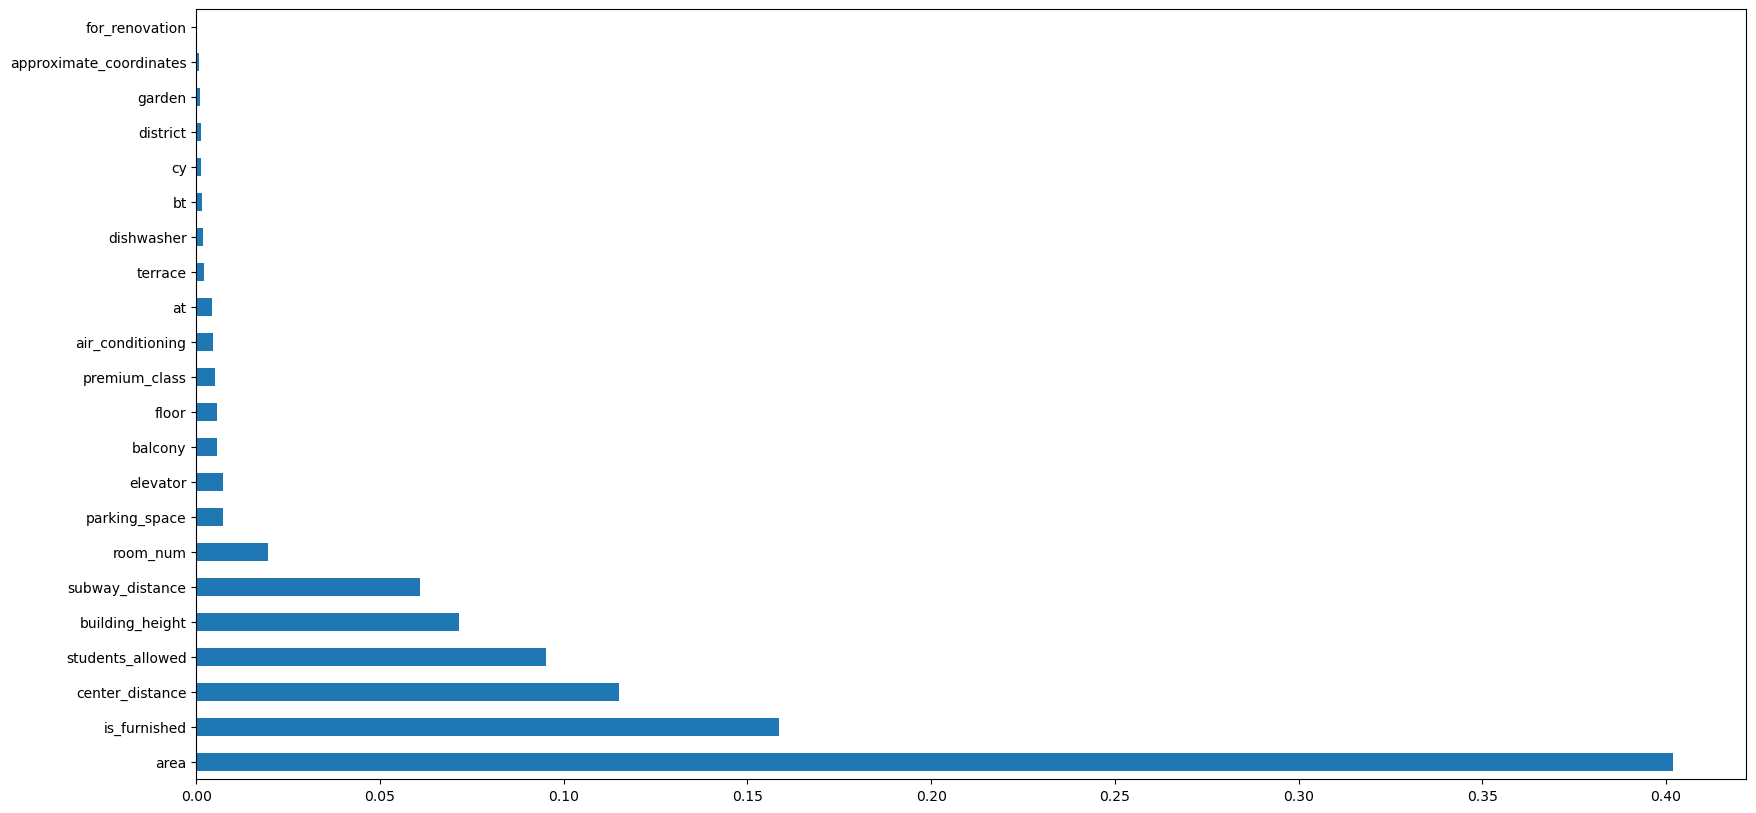

In [40]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y)

plt.rcParams['figure.figsize'] = [20, 10]

feature_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feature_importances_means = feature_importances.groupby(
    lambda x: x.split('_')[0] if x.startswith(prefixes) else x).mean().sort_values(ascending=False)

feature_importances_means.plot(kind='barh')

plt.show()

In [42]:
x_to_drop = ['for_renovation', 'garden', 'approximate_coordinates']
x_train.drop(x_to_drop, axis=1, inplace=True)
x_test.drop(x_to_drop, axis=1, inplace=True)

### Training models

In [44]:
hyper_store = ['params', 'mean_test_MAE', 'mean_test_MSE', 'mean_test_R2']

scoring = {
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

Random Forest

In [ ]:
param_distributions = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "min_samples_split": uniform(0.01, 0.1),
    "min_samples_leaf": uniform(0.01, 0.1),
    "n_jobs": [-1]
}

rf = RandomForestRegressor()

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,
    cv=6,
    scoring= scoring,
    refit='MSE',
    return_train_score=False,
    random_state=42
)

random_search_rf.fit(x_train, y)

results = random_search_rf.cv_results_

hyperparameter_results = pd.DataFrame(results)[hyper_store]

In [ ]:
hyperparameter_results.insert(0,'algorithm', 'RandomForest')

XGBoost

In [ ]:
param_distributions = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 5),
    "n_jobs": [-1]
}

xg_reg = xgb.XGBRegressor()

random_search_xg = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_distributions,
    n_iter=100,
    cv=6,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    random_state=42
)

random_search_xg.fit(x_train, y)

results_xgb = random_search_xg.cv_results_
results_df_xgb = pd.DataFrame(results_xgb)[hyper_store]
results_df_xgb.insert(0,'algorithm', 'XGBoost')

hyperparameter_results = pd.concat([hyperparameter_results, results_df_xgb], ignore_index=True)

Lasso

In [ ]:
param_distributions_lasso = {
    "alpha": uniform(0.0001, 1.0)
}

lasso = Lasso()

random_search_lasso = RandomizedSearchCV(
    estimator=lasso,
    param_distributions=param_distributions_lasso,
    n_iter=100,
    cv=6,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    random_state=42
)

random_search_lasso.fit(x_train, y)

results_lasso = random_search_lasso.cv_results_
results_df_lasso = pd.DataFrame(results_lasso)[hyper_store]
results_df_lasso.insert(0,'algorithm', 'Lasso')

hyperparameter_results = pd.concat([hyperparameter_results, results_df_lasso], ignore_index=True)

In [ ]:
sorted_df = hyperparameter_results.sort_values(by=['algorithm', 'mean_test_MSE'], ascending=[True, False])
sorted_df = sorted_df.groupby('algorithm').head(1).reset_index(drop=True)
numeric_cols = sorted_df.select_dtypes(include=[np.number]).columns
sorted_df[numeric_cols] = sorted_df[numeric_cols].abs()
sorted_df

### Evaluation on out of sample data

In [ ]:
results_comparison = {
    'Model': ['RandomForest', 'XGBoost', 'Lasso'],
    'MSE': [],
    'MAE': [],
    'R2': []
}

random_search_objects = [random_search_rf, random_search_xg, random_search_lasso]

for rs in random_search_objects:
    best_model = rs.best_estimator_
    predictions = best_model.predict(x_test)
    
    results_comparison['MSE'].append(mean_squared_error(y_test, predictions))
    results_comparison['MAE'].append(mean_absolute_error(y_test, predictions))
    results_comparison['R2'].append(r2_score(y_test, predictions))

results_df = pd.DataFrame(results_comparison)

results_df